<a target="_blank" href="https://colab.research.google.com/github/Jasonchen0317/CSGY-6613-Assignment/blob/main/assignment-2/assignment_2_rareEvents.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [26]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import optuna
import matplotlib.pyplot as plt
import math

from keras import layers
from keras import models 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [3]:
import os, shutil

Start from loading the images

In [4]:
#Extract the zip files
train_path = "C:/kaggle/dogs-vs-cats/train.zip"
test_path = "C:/kaggle/dogs-vs-cats/test1.zip"

files = "C:/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [4]:
#read in the image file names to pd dataframe
image_dir = "C:/kaggle/working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [5]:
#Sample 4000 files
data = data.sample(frac =0.16) 

In [7]:
#Split the data into 2000 training, 1000 test, 1000 validation
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.5, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (1000, 2)
The shape of validation data (1000, 2)


In [8]:
#Set parameters
image_size = 150
image_channel = 3
bat_size = 20

In [9]:
#Image data generator. Rescale, rotation, shift, zoom, etc. on the training datas. Rescale the test and valid data
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
#Generate the image datas
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
validation_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


Use optuna the tune the hyperparameters

In [101]:
#Create cnn model for trials
def create_cnn_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    
    num_hidden = trial.suggest_categorical("num_hidden", [128, 256, 512])
    
    model = models.Sequential()
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters1", [32, 64]),
                kernel_size=trial.suggest_categorical("kernel_size1", [3, 5]),
                activation='relu',
                input_shape=(150, 150, 3)
                )
            )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters2", [32, 64]),
                kernel_size=trial.suggest_categorical("kernel_size2", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters3", [64, 128]),
                kernel_size=trial.suggest_categorical("kernel_size3", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
                filters=trial.suggest_categorical("filters4", [64, 128]),
                kernel_size=trial.suggest_categorical("kernel_size4", [3, 5]),
                activation='relu'
                )
            )
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_hidden, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    
    
    
    return model

In [102]:
#Create optimizer for trials
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [103]:
#Objective function 
def objective_cnn(trial):
    # Get MNIST data.

    # Build model and optimizer.
    model = create_cnn_model(trial)
    
    optimizer = create_optimizer(trial)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      batch_size=128
    )
    score = model.evaluate(test_generator, verbose=0)
    return score[1]

In [104]:
#Find the best hyperparameters for the model
study = optuna.create_study(direction="maximize")
study.optimize(objective_cnn, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-05 20:58:17,822] A new study created in memory with name: no-name-d8e76212-7b04-4f61-b204-d5a5bde5e8bf


Epoch 1/10
100/100 [==============================] - 19s 175ms/step - loss: 0.6942 - accuracy: 0.5195 - val_loss: 0.6908 - val_accuracy: 0.5470
Epoch 2/10
100/100 [==============================] - 17s 175ms/step - loss: 0.6890 - accuracy: 0.5345 - val_loss: 0.6889 - val_accuracy: 0.5740
Epoch 3/10
100/100 [==============================] - 17s 171ms/step - loss: 0.6840 - accuracy: 0.5705 - val_loss: 0.6860 - val_accuracy: 0.5450
Epoch 4/10
100/100 [==============================] - 17s 173ms/step - loss: 0.6791 - accuracy: 0.5810 - val_loss: 0.6828 - val_accuracy: 0.6140
Epoch 5/10
100/100 [==============================] - 27s 273ms/step - loss: 0.6716 - accuracy: 0.6030 - val_loss: 0.6823 - val_accuracy: 0.5210
Epoch 6/10
100/100 [==============================] - 37s 364ms/step - loss: 0.6623 - accuracy: 0.6125 - val_loss: 0.6719 - val_accuracy: 0.6080
Epoch 7/10
100/100 [==============================] - 17s 170ms/step - loss: 0.6505 - accuracy: 0.6395 - val_loss: 0.6662 - val_ac

[I 2023-10-05 21:01:42,781] Trial 0 finished with value: 0.6549999713897705 and parameters: {'n_cov_layers': 4, 'n_layers': 3, 'weight_decay': 7.418119526344144e-10, 'num_hidden': 512, 'filters1': 32, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 3, 'filters3': 64, 'kernel_size3': 3, 'filters4': 128, 'kernel_size4': 3, 'optimizer': 'Adam', 'adam_learning_rate': 1.7063662242594414e-05}. Best is trial 0 with value: 0.6549999713897705.


Epoch 1/10
100/100 [==============================] - 62s 593ms/step - loss: 2.2378 - accuracy: 0.4890 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 2/10
100/100 [==============================] - 57s 572ms/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 3/10
100/100 [==============================] - 57s 570ms/step - loss: 0.6935 - accuracy: 0.4835 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 4/10
100/100 [==============================] - 57s 566ms/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 5/10
100/100 [==============================] - 57s 571ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 6/10
100/100 [==============================] - 56s 559ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/10
100/100 [==============================] - 56s 559ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6931 - val_ac

[I 2023-10-05 21:12:21,975] Trial 1 finished with value: 0.5019999742507935 and parameters: {'n_cov_layers': 4, 'n_layers': 3, 'weight_decay': 3.3360451799775936e-09, 'num_hidden': 512, 'filters1': 64, 'kernel_size1': 5, 'filters2': 64, 'kernel_size2': 5, 'filters3': 128, 'kernel_size3': 5, 'filters4': 128, 'kernel_size4': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.006348331710411272}. Best is trial 0 with value: 0.6549999713897705.


Epoch 1/10
100/100 [==============================] - 21s 194ms/step - loss: 0.9126 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/10
100/100 [==============================] - 19s 194ms/step - loss: 0.6937 - accuracy: 0.4890 - val_loss: 0.6929 - val_accuracy: 0.5020
Epoch 3/10
100/100 [==============================] - 21s 208ms/step - loss: 0.6934 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 5/10
100/100 [==============================] - 20s 196ms/step - loss: 0.6939 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 6/10
100/100 [==============================] - 19s 194ms/step - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/10
 71/100 [====================>.........] - ETA: 5s - loss: 0.6933 - accuracy: 0.4817

[W 2023-10-05 21:14:34,746] Trial 2 failed with parameters: {'n_cov_layers': 1, 'n_layers': 2, 'weight_decay': 8.491018235122244e-10, 'num_hidden': 128, 'filters1': 32, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 3, 'filters3': 64, 'kernel_size3': 5, 'filters4': 128, 'kernel_size4': 3, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0026014434217833675, 'rmsprop_weight_decay': 0.8961086735181216, 'rmsprop_momentum': 1.0789961986272138e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\jason\AppData\Local\Temp\ipykernel_20800\3068453465.py", line 13, in objective_cnn
    model.fit(
  File "C:\Users\jason\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    retur

KeyboardInterrupt: 

Best trial:

  Value: 0.7910000085830688
  
  Params: 

    num_hidden: 128
    filters1: 64
    kernel_size1: 3
    filters2: 64
    kernel_size2: 3
    filters3: 128
    kernel_size3: 3
    filters4: 64
    kernel_size4: 5
    optimizer: Adam
    adam_learning_rate: 0.00019015061410741497

Build and Train the model

In [11]:
#build cnn model with the best trial parameters
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [12]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00019),
              metrics=['acc'])

In [16]:
#Train model with original, balanced data
history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size
    )

Epoch 1/100
100/100 [==============================] - 60s 599ms/step - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6841 - val_acc: 0.5890
Epoch 2/100
100/100 [==============================] - 81s 807ms/step - loss: 0.6829 - acc: 0.5560 - val_loss: 0.7076 - val_acc: 0.5030
Epoch 3/100
100/100 [==============================] - 42s 420ms/step - loss: 0.6660 - acc: 0.5765 - val_loss: 0.6372 - val_acc: 0.5940
Epoch 4/100
100/100 [==============================] - 51s 513ms/step - loss: 0.6712 - acc: 0.5605 - val_loss: 0.6399 - val_acc: 0.6180
Epoch 5/100
100/100 [==============================] - 43s 427ms/step - loss: 0.6512 - acc: 0.6080 - val_loss: 0.6935 - val_acc: 0.5990
Epoch 6/100
100/100 [==============================] - 38s 380ms/step - loss: 0.6397 - acc: 0.6160 - val_loss: 0.5954 - val_acc: 0.6950
Epoch 7/100
100/100 [==============================] - 32s 315ms/step - loss: 0.6232 - acc: 0.6350 - val_loss: 0.5945 - val_acc: 0.6980
Epoch 8/100
100/100 [===========================

In [11]:
model.save('my_model.keras')

NameError: name 'model' is not defined

Plot the loss and accuracy of the model over the training and validation data during training:

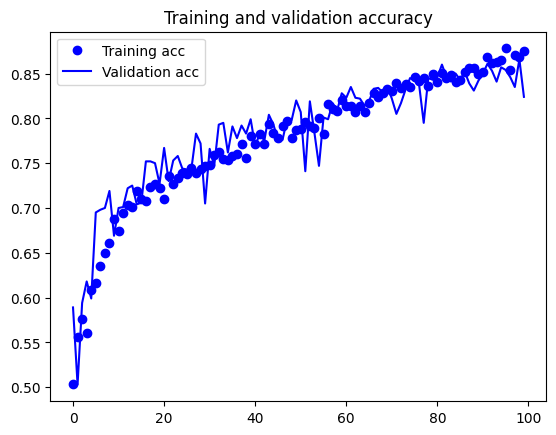

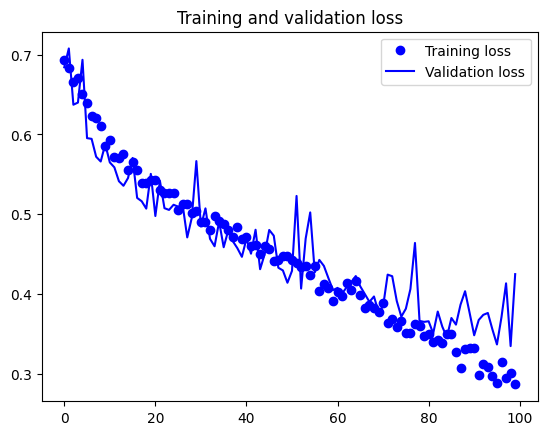

In [18]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
#Function for plotting roc curve
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0,1], [0,1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True_Positive_Rate')
    plt.title('ROC')
    plt.legend()
    plt.show()
    

In [15]:
#Function for plotting recall_precision curve
def plot_recall_precision(recall, precision):
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

#add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

#display plot
    plt.show()

In [12]:
#Load trained model
model = tf.keras.models.load_model('my_model.keras')

Plot the ROC curves ,the Recall-Precision curves, and the confusion matrix

50/50 [==============================] - 4s 72ms/step


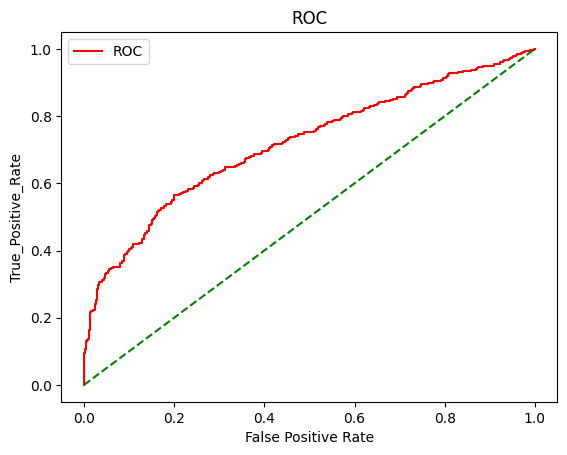

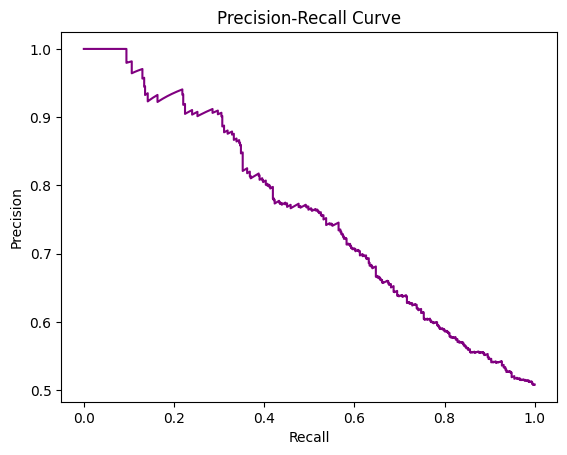

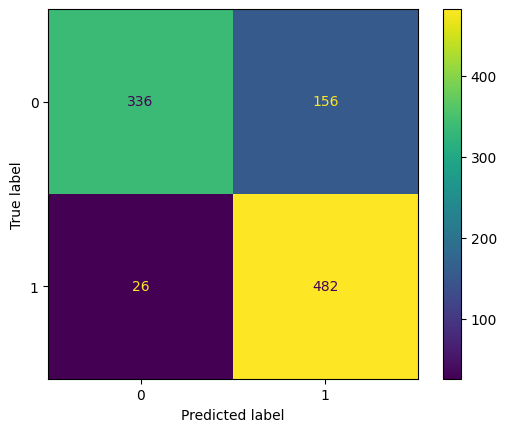

In [25]:
#Plot the ROC curves and the Recall-Precision curves
prob = model.predict(validation_generator)
y_pred_prob = np.amax(prob, axis=1)
y_pred = np.argmax(prob, axis=1)

fper, tper, threshold = roc_curve(validation_generator.classes, y_pred_prob)
plot_roc_curve(fper, tper)

precision, recall, thresholds = precision_recall_curve(validation_generator.classes, y_pred_prob)
plot_recall_precision(recall, precision)

ConfusionMatrixDisplay.from_predictions(validation_generator.classes, y_pred)
plt.show()

Resample data to create 10% and 1% cat dataset

In [48]:
#Load data file names
image_dir = "C:/kaggle/working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [49]:
#sample 10% and 1% of cat images, then combine with the original dog images
grouped = data.groupby(data['label'] =='cat')

cat_data = grouped.get_group(True)
dog_data = grouped.get_group(False)
print(dog_data.shape)


cat_data_10 = cat_data.sample(frac =0.1) 
print(cat_data_10.shape)
rare10_data = pd.concat([cat_data_10, dog_data])

cat_data_1 = cat_data.sample(frac =0.01) 
print(cat_data_1.shape)
rare1_data = pd.concat([cat_data_1, dog_data])

print(rare10_data.shape)
print(rare1_data.shape)

(12500, 2)
(1250, 2)
(125, 2)
(13750, 2)
(12625, 2)


In [50]:
#Sample about 4000 datas for each dataset
rare10_data_sample = rare10_data.sample(frac=0.29) 
rare1_data_sample = rare1_data.sample(frac=0.316) 
print(rare10_data_sample.shape)
print(rare1_data_sample.shape)

(3987, 2)
(3990, 2)


In [86]:
#create directory for storing newly distributed data
if not os.path.exists('data/data10'):
   os.makedirs('data/data10')
if not os.path.exists('data/data1'):
   os.makedirs('data/data1')


In [91]:
#Save the new data
import shutil

src_path = "C:/kaggle/working/train/"
dst_path = "data/data10/"
print('Copied')
for ind in rare10_data_sample.index:
    shutil.copy(src_path+rare10_data_sample['filename'][ind], dst_path+rare10_data_sample['filename'][ind])
    
dst_path = "data/data1/"
print('Copied')
for ind in rare1_data_sample.index:
    shutil.copy(src_path+rare1_data_sample['filename'][ind], dst_path+rare1_data_sample['filename'][ind])

Copied
Copied


In [51]:
#split the 10% cat data
labels = rare10_data_sample['label']

X_train, X_temp = train_test_split(rare10_data_sample, test_size=0.5, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

In [52]:
#generate 10%-cat data
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
validation_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 1993 validated image filenames belonging to 2 classes.
Found 997 validated image filenames belonging to 2 classes.
Found 997 validated image filenames belonging to 2 classes.


Retrain the model with 10% cat dataset

In [53]:
#model for 10% cat data
model1 = models.Sequential()
model1.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(2, activation='sigmoid'))

from keras import optimizers
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00019),
              metrics=['acc'])

In [54]:
#retrain with 10% cat data
history = model1.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size
    )

Epoch 1/20
100/100 [==============================] - 35s 337ms/step - loss: 0.3121 - acc: 0.9147 - val_loss: 0.2814 - val_acc: 0.9147
Epoch 2/20
100/100 [==============================] - 30s 303ms/step - loss: 0.2963 - acc: 0.9147 - val_loss: 0.2814 - val_acc: 0.9147
Epoch 3/20
100/100 [==============================] - 31s 310ms/step - loss: 0.2902 - acc: 0.9147 - val_loss: 0.2762 - val_acc: 0.9147
Epoch 4/20
100/100 [==============================] - 32s 318ms/step - loss: 0.2948 - acc: 0.9147 - val_loss: 0.2772 - val_acc: 0.9147
Epoch 5/20
100/100 [==============================] - 32s 318ms/step - loss: 0.2885 - acc: 0.9147 - val_loss: 0.2821 - val_acc: 0.9147
Epoch 6/20
100/100 [==============================] - 31s 305ms/step - loss: 0.2813 - acc: 0.9147 - val_loss: 0.3068 - val_acc: 0.9147
Epoch 7/20
100/100 [==============================] - 31s 306ms/step - loss: 0.2823 - acc: 0.9147 - val_loss: 0.2916 - val_acc: 0.9147
Epoch 8/20
100/100 [==============================] - 3

50/50 [==============================] - 4s 68ms/step


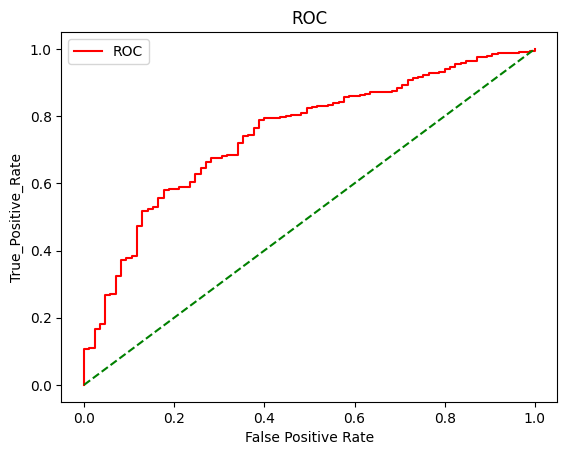

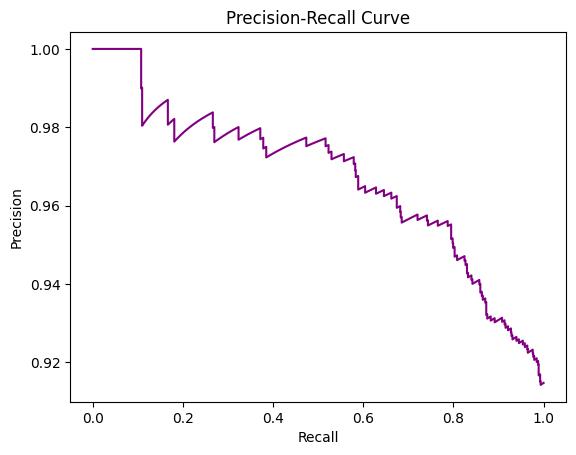

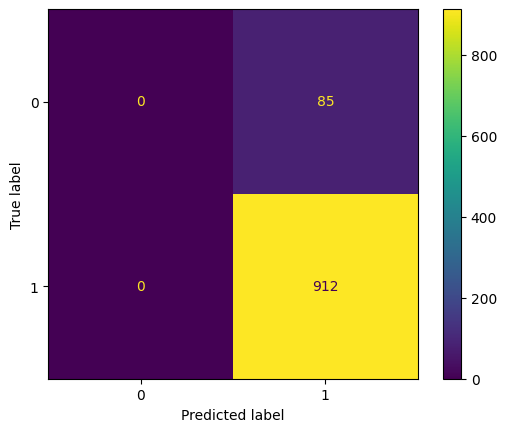

In [56]:
#Plot the ROC curves and the Recall-Precision curves
prob = model1.predict(validation_generator)
y_pred_prob = np.amax(prob, axis=1)
y_pred = np.argmax(prob, axis=1)

fper, tper, threshold = roc_curve(validation_generator.classes, y_pred_prob)
plot_roc_curve(fper, tper)

precision, recall, thresholds = precision_recall_curve(validation_generator.classes, y_pred_prob)
plot_recall_precision(recall, precision)

ConfusionMatrixDisplay.from_predictions(validation_generator.classes, y_pred)
plt.show()

The model predicted all the images as dog. Although the overall accuracy is high, the accuracy for classifying cat image is very low.

Improvement 1: Square root Sampling

In [82]:
#squareroot sampling
catsize_sqrt = math.sqrt(cat_data_10.shape[0])
dog_size_sqrt = math.sqrt(dog_data.shape[0])

samplesize = cat_data_10.shape[0]/catsize_sqrt*dog_size_sqrt
dog_data_resample = dog_data.sample(n=int(samplesize)) 

sqrt_sample_data = pd.concat([dog_data_resample, cat_data_10])

In [83]:
#Split the data
labels = sqrt_sample_data['label']

X_train, X_temp = train_test_split(sqrt_sample_data, test_size=0.5, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

In [84]:
#generate square root sample data
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
validation_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 2601 validated image filenames belonging to 2 classes.
Found 1301 validated image filenames belonging to 2 classes.
Found 1300 validated image filenames belonging to 2 classes.


In [85]:
#model for squareroot sampled data
model_sqrt = models.Sequential()
model_sqrt.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_sqrt.add(layers.MaxPooling2D((2, 2)))
model_sqrt.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_sqrt.add(layers.MaxPooling2D((2, 2)))
model_sqrt.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_sqrt.add(layers.MaxPooling2D((2, 2)))
model_sqrt.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_sqrt.add(layers.MaxPooling2D((2, 2)))
model_sqrt.add(layers.Flatten())
model_sqrt.add(layers.Dropout(0.5))
model_sqrt.add(layers.Dense(512, activation='relu'))
model_sqrt.add(layers.Dense(2, activation='sigmoid'))

from keras import optimizers
model_sqrt.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00019),
              metrics=['acc'])

In [86]:
#retrain with squareroot sampled data
history = model_sqrt.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size
    )

Epoch 1/20
100/100 [==============================] - 36s 330ms/step - loss: 0.5522 - acc: 0.7577 - val_loss: 0.5321 - val_acc: 0.7640
Epoch 2/20
100/100 [==============================] - 33s 332ms/step - loss: 0.5466 - acc: 0.7653 - val_loss: 0.5316 - val_acc: 0.7640
Epoch 3/20
100/100 [==============================] - 32s 316ms/step - loss: 0.5427 - acc: 0.7547 - val_loss: 0.5617 - val_acc: 0.7640
Epoch 4/20
100/100 [==============================] - 32s 322ms/step - loss: 0.5438 - acc: 0.7550 - val_loss: 0.5369 - val_acc: 0.7640
Epoch 5/20
100/100 [==============================] - 32s 318ms/step - loss: 0.5314 - acc: 0.7612 - val_loss: 0.5279 - val_acc: 0.7640
Epoch 6/20
100/100 [==============================] - 32s 316ms/step - loss: 0.5317 - acc: 0.7630 - val_loss: 0.5450 - val_acc: 0.7640
Epoch 7/20
100/100 [==============================] - 32s 324ms/step - loss: 0.5268 - acc: 0.7640 - val_loss: 0.5003 - val_acc: 0.7680
Epoch 8/20
100/100 [==============================] - 3

66/66 [==============================] - 5s 74ms/step


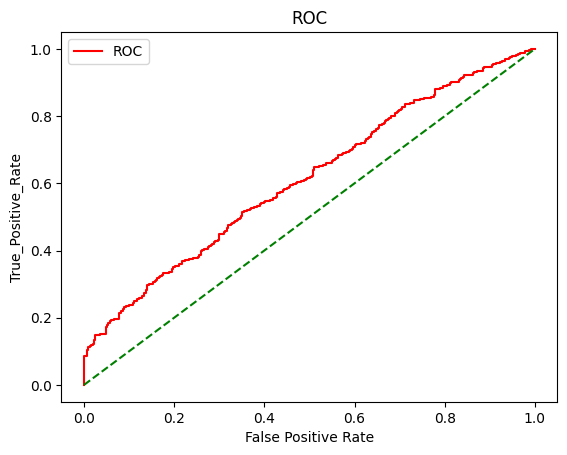

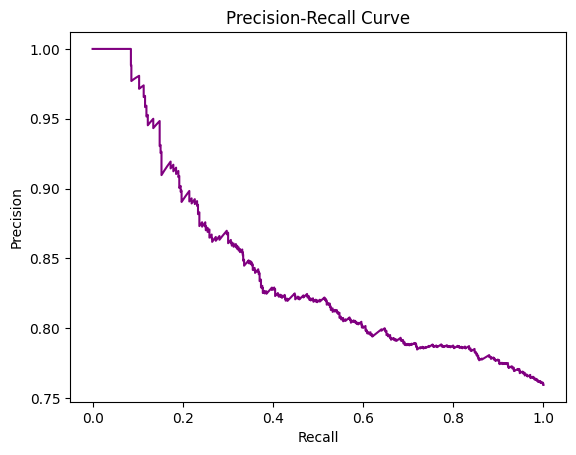

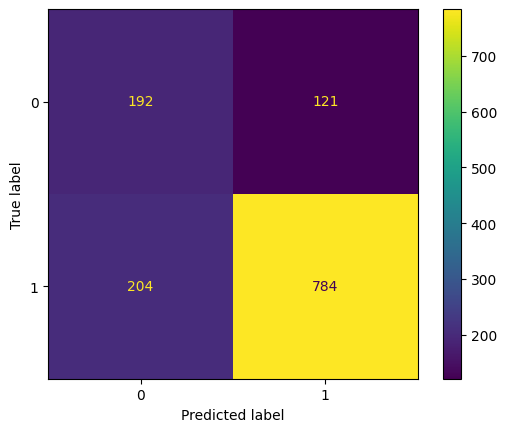

In [87]:
#Plot the ROC curves and the Recall-Precision curves
prob = model1.predict(validation_generator)
y_pred_prob = np.amax(prob, axis=1)
y_pred = np.argmax(prob, axis=1)

fper, tper, threshold = roc_curve(validation_generator.classes, y_pred_prob)
plot_roc_curve(fper, tper)

precision, recall, thresholds = precision_recall_curve(validation_generator.classes, y_pred_prob)
plot_recall_precision(recall, precision)

ConfusionMatrixDisplay.from_predictions(validation_generator.classes, y_pred)
plt.show()

Result: The accuracy of the cat image has improved

Improvement 2: normalized classifier

In [104]:
#split the 10% cat data
labels = rare10_data_sample['label']

X_train, X_temp = train_test_split(rare10_data_sample, test_size=0.5, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

In [105]:
#generate 10%-cat data
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
validation_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 1993 validated image filenames belonging to 2 classes.
Found 997 validated image filenames belonging to 2 classes.
Found 997 validated image filenames belonging to 2 classes.


In [94]:
#model for normalized classifier model
model_w = models.Sequential()
model_w.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model_w.add(layers.MaxPooling2D((2, 2)))
model_w.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_w.add(layers.MaxPooling2D((2, 2)))
model_w.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_w.add(layers.MaxPooling2D((2, 2)))
model_w.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_w.add(layers.MaxPooling2D((2, 2)))
model_w.add(layers.Flatten())
model_w.add(layers.Dropout(0.5))
model_w.add(layers.Dense(512, activation='relu'))
model_w.add(layers.Dense(2, activation='sigmoid'))

from keras import optimizers
model_w.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.00019),
              metrics=['acc'])


In [100]:
class_weight = {
    0: 10,
    1: 1
}

In [108]:
#retrain with squareroot sampled data
history = model_w.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size,
      class_weight=class_weight
    )

Epoch 1/100
100/100 [==============================] - 92s 926ms/step - loss: 0.9788 - acc: 0.7255 - val_loss: 0.3796 - val_acc: 0.8576
Epoch 2/100
100/100 [==============================] - 105s 1s/step - loss: 1.0230 - acc: 0.7035 - val_loss: 0.4434 - val_acc: 0.8014
Epoch 3/100
100/100 [==============================] - 106s 1s/step - loss: 1.0052 - acc: 0.7140 - val_loss: 0.6586 - val_acc: 0.6088
Epoch 4/100
100/100 [==============================] - 102s 1s/step - loss: 0.9951 - acc: 0.7230 - val_loss: 0.4707 - val_acc: 0.8084
Epoch 5/100
100/100 [==============================] - 31s 314ms/step - loss: 0.9941 - acc: 0.7280 - val_loss: 0.5354 - val_acc: 0.7342
Epoch 6/100
100/100 [==============================] - 70s 703ms/step - loss: 1.0155 - acc: 0.7391 - val_loss: 0.4661 - val_acc: 0.8124
Epoch 7/100
100/100 [==============================] - 55s 550ms/step - loss: 0.9521 - acc: 0.7416 - val_loss: 0.3467 - val_acc: 0.8786
Epoch 8/100
100/100 [==============================] -

50/50 [==============================] - 4s 74ms/step


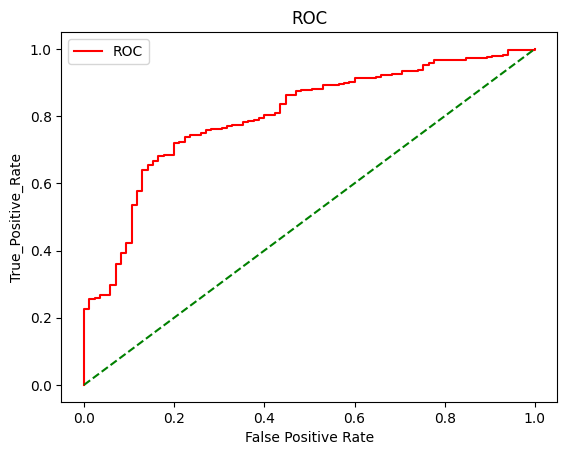

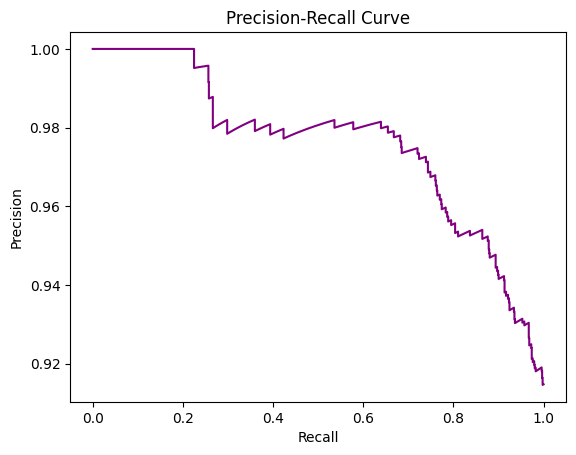

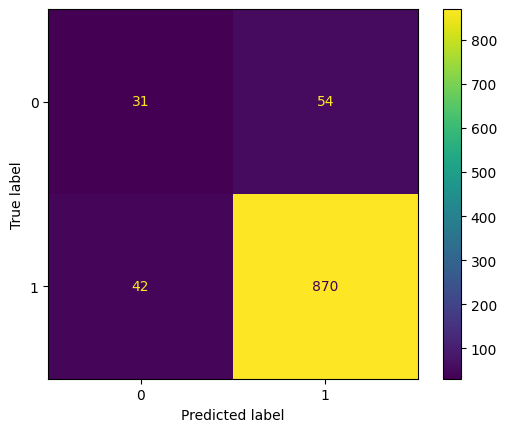

In [109]:
#Plot the ROC curves and the Recall-Precision curves
prob = model_w.predict(validation_generator)
y_pred_prob = np.amax(prob, axis=1)
y_pred = np.argmax(prob, axis=1)

fper, tper, threshold = roc_curve(validation_generator.classes, y_pred_prob)
plot_roc_curve(fper, tper)

precision, recall, thresholds = precision_recall_curve(validation_generator.classes, y_pred_prob)
plot_recall_precision(recall, precision)

ConfusionMatrixDisplay.from_predictions(validation_generator.classes, y_pred)
plt.show()

Clear improvement for classifying cat images, total accuracy close to balanced data